In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import numpy as np
from scipy.integrate import solve_ivp
import pandas as pd
import scipy.constants as const
from scipy.interpolate import UnivariateSpline
from scipy.optimize import minimize

In [24]:
def data_reader(file_name = 'white_dwarf_data.csv'):
   """
    Reads white dwarf data from a CSV file.
    """
   data = pd.read_csv(file_name) # Read data
   mass_solar = data['mass'].values
   logg = data['logg'].values
   return mass_solar, logg

In [25]:
def scaler(M, logg):
    """
    Converts white dwarf data mass in solar masses, logg in cgs to mass in kg and radius in m.

    """
    M_sun = 1.988e30 # kg
    R_earth = 6.371e6 # m
    G = const.gravitational_constant

    g = (10 ** logg) * (10 ** (-2)) # in SI units
    mass = M * M_sun # mass in kg
    R = np.sqrt(G * mass / g) # radius in m
    R = R / R_earth
    return M, R

In [26]:
def mass_radius_fit_and_plot(mass, radius, threshold):
    """
    Plots a scatter plot of mass vs. radius and fits a curve M = c * R^((3-n)/(1-n)) 
    to points with mass below a given threshold.
    """
    # Filter data based on the threshold
    mask = mass < threshold
    mass_fit = mass[mask]
    radius_fit = radius[mask]

    # Define the fit function
    def mass_radius_equation(R, A, n):
        exponent = (3 - n) / (1 - n)
        return A * R**exponent

    # Perform the curve fitting
    popt, _ = curve_fit(mass_radius_equation, radius_fit, mass_fit, p0 = (1.5, 1.5))

    # Extract fit parameters
    A, n = popt

    # Generate fitted curve
    radius_range = np.linspace(min(radius_fit), max(radius_fit), 500)
    fitted_mass = mass_radius_equation(radius_range, A, n)

    # Plot the data and the fitted curve
    plt.figure(figsize=(6, 4))
    plt.scatter(radius[~mask], mass[~mask], color='pink', s=20, alpha=0.7, label='Not Fitted Points')
    plt.scatter(radius_fit, mass_fit, color='green', s=20, alpha=0.7, label='Fitted Points')
    plt.plot(radius_range, fitted_mass, color='orange', linestyle='-', linewidth=2, label=f"Curve Fit (A={A:.2f}, n={n:.2f})")
    plt.title("White Dwarf Mass vs Radius")
    plt.xlabel("Radius (Earth Radii)")
    plt.ylabel("Mass (Solar Masses)")
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()
    print(f"Fit Parameters: A = {A}, n = {n}")

    return n, A

In [27]:
def mass_radius_fit_and_plot_fixed_n(mass, radius, threshold, n = 1.5):
    """
    Plots a scatter plot of mass vs. radius and fits a curve M = c * R^((3-n)/(1-n)) 
    to points with mass below a given threshold, with n fixed.
    """
    # Filter data based on the threshold
    mask = mass < threshold
    mass_fit = mass[mask]
    radius_fit = radius[mask]

    # Define the fit function with n fixed
    def mass_radius_equation(R, A):
        exponent = (3 - n) / (1 - n)
        return A * R ** exponent

    # Perform the curve fitting
    popt, _ = curve_fit(mass_radius_equation, radius_fit, mass_fit, p0 = (1.5,))

    # Extract the fit parameter
    A = popt[0]

    print(f"Fit Parameter For n = {n}: A = {A:.2f}")
    return A

In [28]:
def calculate_K(B, n, xi_n, der_theta_xi_n):
    """
    Calculates polytropic constant K for a white dwarf
    """
    G = const.G
    K = ((B / (4 * np.pi * (xi_n ** 5) * (-der_theta_xi_n))) ** (1 / 3)) * (4 * np.pi * G / 2.5)
    return K

In [29]:
def lane_emden_solver(n):
    """
    Solves the Lane-Emden equation for a given polytropic index n from xi=0 to xi=xi_final.
    The Lane-Emden equation is:
        1/xi^2 d/dxi(xi^2 dtheta/dxi) + theta^n = 0
    """
    dxi = 0.01 # step distances
    N = 100000

    xi = 0.0001 
    theta = 1.0
    f = 0.0
    theta_sol = []
    xi_sol = []

    for i in range(N):
        f += -xi ** 2 * theta ** n * dxi
        theta += f / xi ** 2 * dxi
        xi += dxi
        theta_sol.append(theta)
        xi_sol.append(xi)
        if (theta_sol[i]*theta_sol[i-1]<0): # stopping condition where we found a solution
            break
            
    der_theta_xi = theta_sol[i]-theta_sol[i-1]/dxi # derivative of theta wrt xi
    
    return xi, der_theta_xi

In [30]:
def solve_chan(D, rho_c, limit = 5,met = 'LSODA'):
    """
    Customized ODE solver for the Chandrasekhar equation 
    with a specific dimensionless parameter D and central density rho_c.
    """
    def f(t, y):
        y_c = np.sqrt((rho_c/D) + 1)
        dydt = [y[1], (-2 / t) * y[1] - (y[0] ** 2 - (1 / y_c ** 2)) ** (3 / 2)]
        return dydt
        
    y_c = np.sqrt((rho_c / D) + 1)
    dt = 0.01
    tspan = np.linspace(0 + dt,limit, 100)  
    yinit = [1,0]
    
    sol = solve_ivp(lambda t, y: f(t, y), [tspan[0], tspan[-1]], yinit, method = met, t_eval = tspan)
    surface = 1 / (y_c)
    return sol,surface

In [31]:
def find_D(M, R, K):

    """
    Finds the dimensionless parameter D by matching a theoretical 
    Chandrasekhar model to the observed mass-radius data.
    """

    ### inital guess ###
    max_iter = 200
    D = 2700000000.0
    dD = 1e6
    rho_c = np.linspace(10**10, 10**8, 20)
    tol = 1e-4

    ### constants (SI) ###
    G = const.gravitational_constant
    M_sun = 1.988e30 # kg
    R_earth = 6.371e6 # m

    zeta_n = 0
    zeta_prime_n = 0
    Radius = 0
    Mass = 0
    R_new = []
    M_new = []

    for i in range(max_iter):

        # D or rho_c dependent variables
        C = (5 / 8) * K * (D ** (5/3))
        # For each trial rho_c, solve the Chandrasekhar equation
        for rho in rho_c:
            # solve the chandrasekhar for given rho and D
            sol, surface = solve_chan(D, rho, limit = 8.2, met = 'RK45')
            # find the surface
            for j in range(len(sol.t)):
                if (sol.y[0, j] <= surface):
                    zeta_n = sol.t[j]
                    zeta_prime_n = sol.y[1, j]

                elif(sol.y[0,-1]> surface):
                    zeta_n = sol.t[-1]
                    zeta_prime_n = sol.y[1, -1]
                
            # radius
            y_c = np.sqrt(rho / D + 1)
            Beta = np.sqrt((2 * C) / (np.pi * G)) / (D * y_c) # scale factor of radius
            Radius = (Beta*zeta_n)
            # mass
            Mass = 4 * np.pi * (Radius ** 3) * D * (y_c ** 3) * (-zeta_prime_n / zeta_n)
            Mass = Mass/M_sun
            Radius = Radius/R_earth

            R_new.append(Radius)
            M_new.append(Mass)

        R_new = np.array(R_new)
        M_new = np.array(M_new)
        spl = UnivariateSpline(R_new, M_new)
        R_new = []
        M_new = []
    
        # calculate error
        error = 0
        for l in range(len(R)):
            error = error + (M[l] - spl(R[l])) ** 2
            error = error / (len(R))

        # If we're within tolerance, stop searching
        if (error < tol):
            print("D is :", D, "with error: ", error, "corresponding C is: ", C)
            x = np.linspace(0, 2.8, 500)

            plt.figure(figsize = (6,4))
            plt.scatter(R, M, label = 'White Dwarf Data', color = 'blue', s = 20, alpha = 0.7)
            plt.plot(x, spl(x), '--', color = 'red', label='Numerical Solution', linewidth = 2)
            plt.xlabel('Radius (Earth Radii)')
            plt.ylabel('Mass (Solar Mass)')
            plt.title('Radius vs Mass of the White Dwarf Data and Numerical Solutions for Calculated D')
            plt.grid()
            plt.legend()
            plt.show()

            break;
      
        if (sum(M) - sum(spl(R)) > 0):
            D = D - dD
        else:
            D = D + dD      
        print(i,"error:",error," and corresponding D: ", D)
        error_ref = error
    return D, C

In [32]:
def chandrasekhar_mass(M, R, D, K, C):
    """
    Computes the Chandrasekhar mass-radius relation by varying central density
    and solving the Chandrasekhar equation, then plots the results.
    """
    rho_c = np.linspace(1e20, 1e22, 200)
    G = const.gravitational_constant
    M_sun = 1.988e30 # kg
    R_earth = 6.371e6 # m

    # find crossing index
    zeta_n = 0
    zeta_prime_n = 0
    Radius = 0
    Mass = 0
    R_new = []
    M_new = []

    for rho in rho_c:
        # solve the chandrasekhar for given rho and D
        sol, surface = solve_chan(D, rho, limit = 8.2 , met = 'RK45')
        
        # find the surface
        for j in range(len(sol.t)):
            if (sol.y[0, j] <= surface):
                zeta_n = sol.t[j]
                zeta_prime_n = sol.y[1, j]

            elif(sol.y[0, -1]> surface):
                zeta_n = sol.t[-1]
                zeta_prime_n = sol.y[1, -1]
        # radius
        y_c = np.sqrt(rho/D + 1)
        Beta = np.sqrt((2*C)/(np.pi*G))/(D*y_c) ## scale factor of radius
        Radius = (Beta*zeta_n)
        
        # mass
        Mass = 4 * np.pi * (Radius ** 3) * D * (y_c ** 3) * (-zeta_prime_n / zeta_n)
        Mass = Mass / M_sun
        Radius = Radius / R_earth

        R_new.append(Radius)
        M_new.append(Mass)

    R_new = np.array(R_new)
    M_new = np.array(M_new)

    plt.figure(figsize = (6,4))
    plt.plot(R_new,M_new,'r--',R_new, M_new,'o')
    plt.title("Mass-Radius Relation of Chandrasekhar Mass for Different Radius")
    plt.xlabel("Radius (Earth Radii)")
    plt.ylabel("Mass(Solar Mass)")
    print("Computational Chandrasekhar Mass: ",M_new[-1],"(in solar mass)")

In [33]:
def lane_emden_solve(n, xi_f = 20):
    """
    Computes the lane emden equation for a given polytropic index n.
    # n is the parameter in Lane-Emden equation
    # xi_f is the final xi value of integration 
    # theta should reach zero before xi_f
    """
    y0 = np.asarray([1, 0]).astype(float) #Initial value

    #RHS of Lane-Emden equation
    def f(t, y):
        f = np.zeros(len(y)) #Initialize to zero vector

        f[0] = y[1]
        if t==0:
            f[1] = 0
        else:
            f[1] = -np.float_power(y[0], n) - (2/t) * y[1]
        return f

    #Calling solver
    sol = solve_ivp(fun=f, t_span=(0,xi_f), y0=y0, method='RK45', max_step = 1e-4)
    
    #Take values from solution
    xi = sol.t
    theta = sol.y[0,:]
    theta_prime = sol.y[1,:]

    #Return final values
    return xi, theta, theta_prime

------Part B------


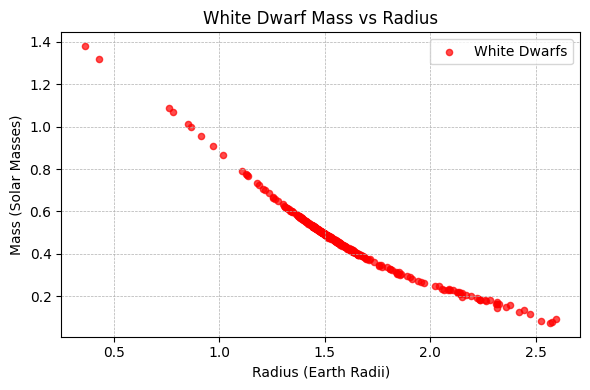

------Part C------


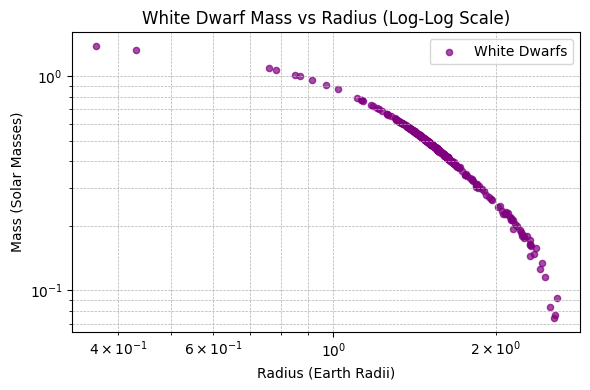

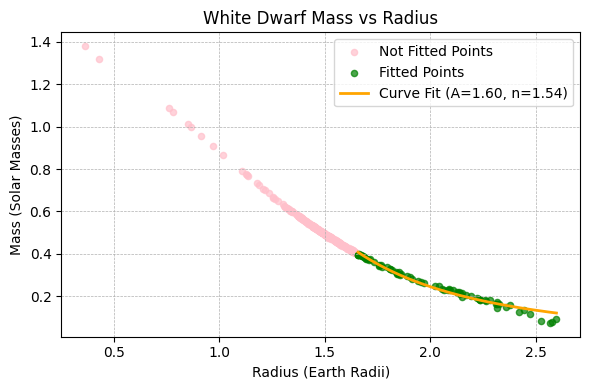

Fit Parameters: A = 1.6045603331967602, n = 1.5387621518933763
the nearest integer for q is:  3
Fit Parameter For n = 1.5: A = 1.91


<IPython.core.display.Math object>

<IPython.core.display.Math object>

Calculated K = 2859370.92


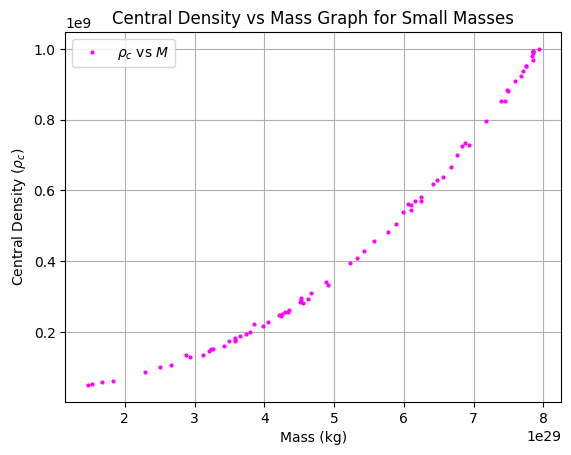

------Part D------


C:\Users\kubra\AppData\Local\Temp\ipykernel_57068\2061494022.py:8: RuntimeWarning: invalid value encountered in scalar power
  dydt = [y[1], (-2 / t) * y[1] - (y[0] ** 2 - (1 / y_c ** 2)) ** (3 / 2)]


D is : 2700000000.0 with error:  1.367929695007955e-05 corresponding C is:  9.355998008411536e+21


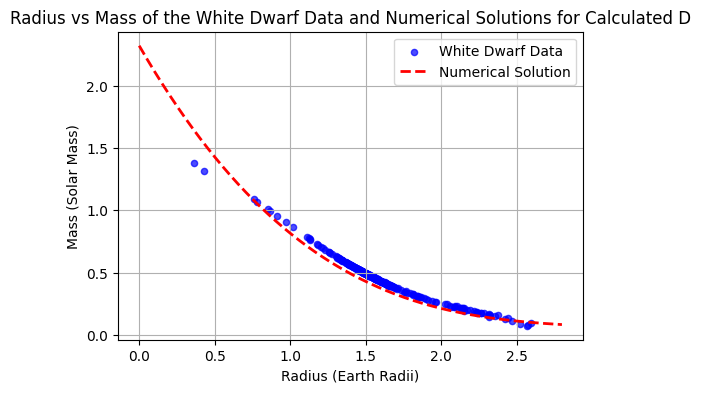

Calculated D =  2700000000.00
Calculated C =  9355998008411535966208.00
Theoretical D = 1947864333.35
Theoretical C = 6002332185660436250624.00
Theoretical K = 2859370.92
------Part E------
Computational Chandrasekhar Mass:  1.4757776474565907 (in solar mass)
xi_3 = 6.896890404199924
theta_prime_xi_3 = -0.04242924348448396
Theoretical value of Chandrasekhar mass = 1.4565978019757557 Solar Masses


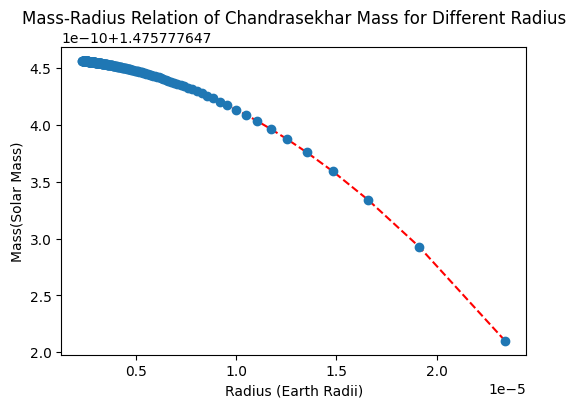

In [34]:
def my_test_newton():

    print("------Part B------")
    M, logg = data_reader()
    M, R = scaler(M, logg)

    # Scatter Plot
    plt.figure(figsize = (6,4))
    plt.scatter(R, M, color = 'red', s = 20, alpha = 0.7, label = 'White Dwarfs')
    plt.title("White Dwarf Mass vs Radius")
    plt.xlabel("Radius (Earth Radii)")
    plt.ylabel("Mass (Solar Masses)")
    plt.grid(True, which = "both", ls = "--", linewidth = 0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()

    print("------Part C------")

    # log-log Scatter Plot
    plt.figure(figsize = (6,4))
    plt.scatter(R, M, color = 'purple', s = 20, alpha = 0.7, label = 'White Dwarfs')
    plt.xscale('log')
    plt.yscale('log')
    plt.title("White Dwarf Mass vs Radius (Log-Log Scale)")
    plt.xlabel("Radius (Earth Radii)")
    plt.ylabel("Mass (Solar Masses)")
    plt.grid(True, which = "both", ls = "--", linewidth = 0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    threshold = 0.4
    M_sun = 1.988e30 # kg
    R_earth = 6.371e6 # m
    G = const.gravitational_constant

    # M_new, R_new = low_mass_radius(M, R, threshold)
    n, A = mass_radius_fit_and_plot(M, R, threshold = threshold)
    print("the nearest integer for q is: ", 3)
    A = mass_radius_fit_and_plot_fixed_n(M, R, threshold = threshold, n = 1.5)
    xi_n, der_theta_xi_n = lane_emden_solver(1.5)
    
    from IPython.display import display, Math
    display(Math(r"\xi_n = {:.2f}".format(xi_n)))
    display(Math(r"\theta'(\xi_n) = {:.2f}".format(der_theta_xi_n)))

    B = A * R_earth**3*(M_sun)
    K = calculate_K(B, n, xi_n, der_theta_xi_n)
    print(f"Calculated K = {K:.2f}")

    mask = M < threshold
    mass_fit = M[mask]
    radius_fit = R[mask]

    mass_fit = mass_fit * M_sun # converting to SI
    radius_fit = radius_fit * R_earth

    rho_c = -(mass_fit * xi_n) / (4 * np.pi * radius_fit ** 3 * der_theta_xi_n) # rho_c using the eq.10

    # Plotting
    plt.plot(mass_fit, rho_c, 'o', markersize = 2, color = 'magenta', label = r'$\rho_c$ vs $M$')
    plt.title("Central Density vs Mass Graph for Small Masses")
    plt.xlabel(r"Mass (kg)")
    plt.ylabel(r"Central Density ($\rho_c$)")
    plt.grid()
    plt.legend()
    plt.show()

    print("------Part D------")
    D, C = find_D(M, R, K)

    print(f"Calculated D =  {D:.2f}")
    print(f"Calculated C =  {C:.2f}")

    from scipy.constants import physical_constants, hbar, c, m_e, atomic_mass

    C_theoretical = ((m_e**4)*(c**5))/(24*(np.pi**2)*(hbar**3))
    D_theoretical = ((3*(np.pi**2)*(hbar**3))/(atomic_mass*(m_e**3)*(c**3)*2))**(-1)
    K_theoretical = (8*C)/(5*(D**(5/3)))

    print(f"Theoretical D = {D_theoretical:.2f}")
    print(f"Theoretical C = {C_theoretical:.2f}")
    print(f"Theoretical K = {K_theoretical:.2f}")

    print("------Part E------")
    
    chandrasekhar_mass(M, R, D, K, C)

    #Solving Lane-Emden Equation for n=3
    xi, theta, theta_prime = lane_emden_solve(n = 3, xi_f=10)
    
    #Finding Intersection Point
    xi_3_idx = np.abs(theta).argmin()
    xi_3 = xi[xi_3_idx]
    theta_prime_xi_3 = theta_prime[xi_3_idx]

    print('xi_3 = ' + str(xi_3))
    print('theta_prime_xi_3 = ' + str(theta_prime_xi_3))

    K_CH = 2*C_theoretical*np.float_power(D_theoretical, -4/3)
    M_CH = -4*np.pi*np.float_power(np.pi * const.gravitational_constant / K_CH, -3/2) * np.float_power(xi_3, 2) * theta_prime_xi_3

    print('Theoretical value of Chandrasekhar mass = ' + str(M_CH/M_sun) + ' Solar Masses')
my_test_newton()